## Week 7: Fitting
<hr style="height: 3.0px"/>

The next couple of lessons we will look at several different types and ways of fitting. All lessons will pull data from the literature using the digitizing function we created in the last couple of lessons.  
1. **Week 7**:  `Scipy curve_fit()`  (this week)  
    a. Application: Crystallization Kinetics of Amorphous $TiO_2$.  (Thin Solid Films 519 (2010) 1649-1654)  
    b. Single Peak Fitting of XRD data  
    c. Integration under a curve  
    d. Fitting Transformation vs Time data to the Avrami Equation (You saw the Avrami equation in Chapter 10 of Callister)  
    
    
2. **Week 8**:  new package: `lmfit` https://lmfit.github.io/lmfit-py/    
    a. We will first learn to install a new package to our Python installation  
    b. Application: Cystallization Kinetics of an ionic liquid (Royal Society of Chemistry Advances (RSC Adv.), 2014, vol. 4, p. 22277)  
    c. Fitting (deconvolution) of two overlapping peaks in calorimetry data  
    
    
3. **Week 9**:  `Scipy optimize()`    
    a. Application:  Creep Analysis of an S590 superalloy Fe-Co-Cr-Ni  
    b. Creating Larsen-Miller Plot from Creep Data (stress vs rupture time) at various temperatures  
    c. Interesting problem because instead of a typical fitting problem, here we are manipulating the set of temperature data curves with a fitting parameter that when found will collapse all the curves to one master curve (the Larsen-Miller plot).  

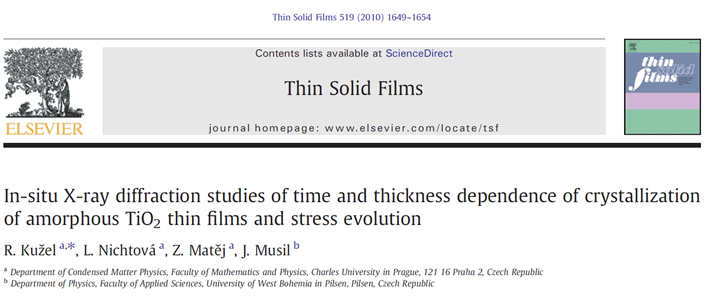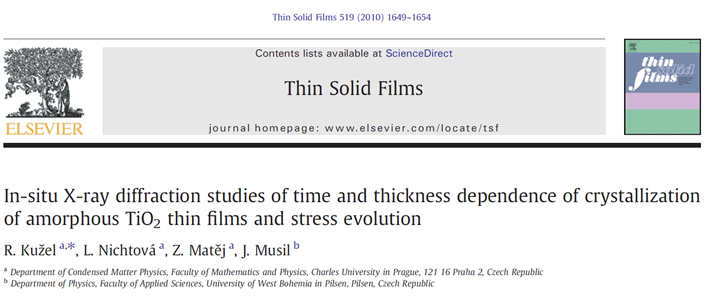

180 nm sample:  
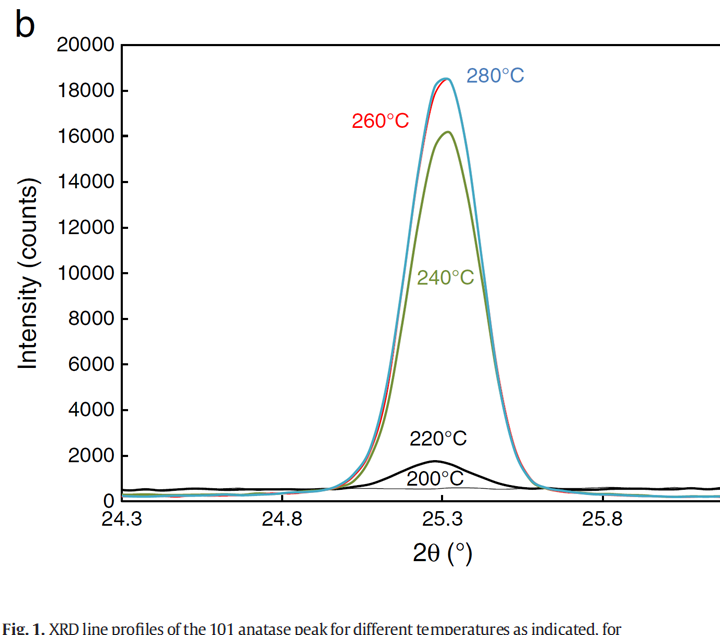

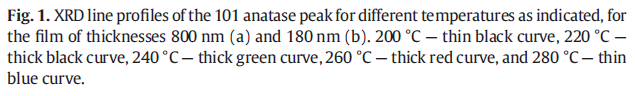

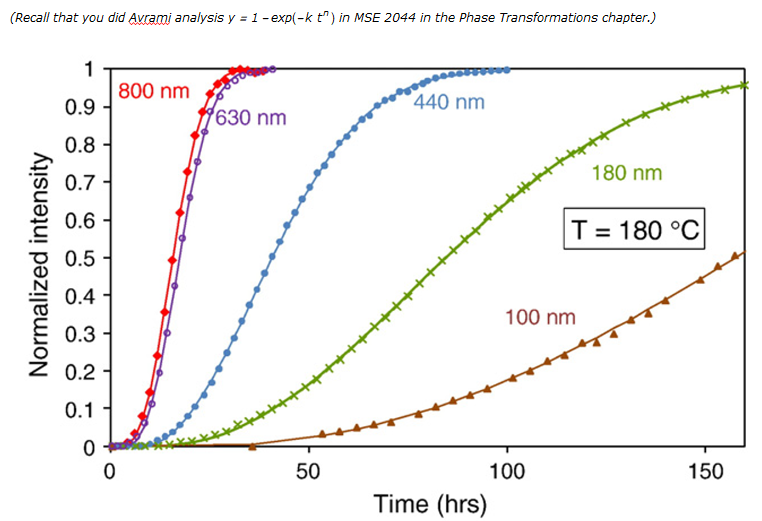

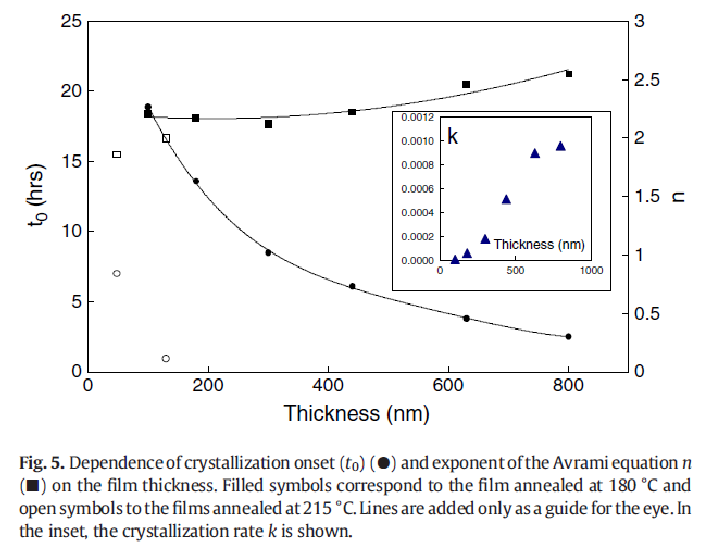

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import sympy as sym
from sympy import solve
import os
%matplotlib notebook

# pixel data stored in variable "pixel_positions"
def selectdata(image_file):
    %matplotlib notebook
    #now we have 1 row and 2 columns i.e. 2 figures in a row
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(9, 4))
    # gridspec_kw={'width_ratios': [2, 2]} can be used above if needed

    # turn off the x, y axis on the image - the axis doesn't make sense for an image
    ax1.axis(False)
    
    img = mpimg.imread(image_file) #matplotlib
    # .add_axes([left, bottom, width, height])
    image_axis = fig.add_axes([0, 0, 0.47, 0.9], zorder=10, anchor=(0.5,0.5)) #zorder places figure on top of anything else in axes
    image_axis.imshow(img)
    image_axis.axis('off')

    # recall from part 1 that image files have coord in left top corner so we need to correct by the y-dimension of the file
    ydim=img.shape[0]

    # setting title and labels for ax1 (figure on the left)
    ax1.set_title('Click on data you want to collect below')
    ax1.set_xlabel('x-pixel position')
    ax1.set_ylabel('y-pixel position')

    global pixel_positions #makes pixel_positions a global variable so we have access to it outside this function
    pixel_positions = []
    def onclick(event):
        if event.button==1:
            pixel_positions.append([event.xdata,ydim-event.ydata])
            ax2.set_title(f'Last click: [{event.xdata:.3f}, {ydim-event.ydata:.3f}]')
            ax2.scatter(event.xdata, ydim-event.ydata, marker='o', c='r', edgecolor='k') #adding scatter plot
    
    cid=fig.canvas.mpl_connect('button_press_event', onclick) 
    fig.show()
    
# enter list of three pixel points and list of three corresponding plot points 
def cal(pixpts, plotpts, datatoconvert):    
    
    xpx1, ypx1 = pixpts[0]
    x1, y1 = plotpts[0]
    xpx2, ypx2 = pixpts[1]
    x2, y2 = plotpts[1]
    xpx3, ypx3 = pixpts[2]
    x3, y3 = plotpts[2]
    
    # general solution for calibration constants
    m11=(x1*ypx2 - x1*ypx3 - x2*ypx1 + x2*ypx3 + x3*ypx1 - x3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m12=-(x1*xpx2 - x1*xpx3 - x2*xpx1 + x2*xpx3 + x3*xpx1 - x3*xpx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m21=(y1*ypx2 - y1*ypx3 - y2*ypx1 + y2*ypx3 + y3*ypx1 - y3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m22=-(-xpx1*y2 + xpx1*y3 + xpx2*y1 - xpx2*y3 - xpx3*y1 + xpx3*y2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    Ox=(-x1*xpx2*y3 + x1*xpx3*y2 + x2*xpx1*y3 - x2*xpx3*y1 - x3*xpx1*y2 + x3*xpx2*y1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    Oy=(x1*y2*ypx3 - x1*y3*ypx2 - x2*y1*ypx3 + x2*y3*ypx1 + x3*y1*ypx2 - x3*y2*ypx1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    
    # define our calibrated transf matrix, m_cal, and our calibrated offset, offset_cal
    m_cal=[[m11, m12],[m21,m22]]
    offset_cal=[Ox, Oy]
    
    # return as numpy arrays
    # return(np.array(m_cal), np.array(offset_cal))
    plot_data=np.array([np.matmul(m_cal, point-offset_cal) for point in np.array(datatoconvert)])

    return(plot_data)


### 1. First click on three points on the plot that you want to use for calibration.  You can zoom your window or magnify your view to get a more accurate selection of points. 

<IPython.core.display.Javascript object>


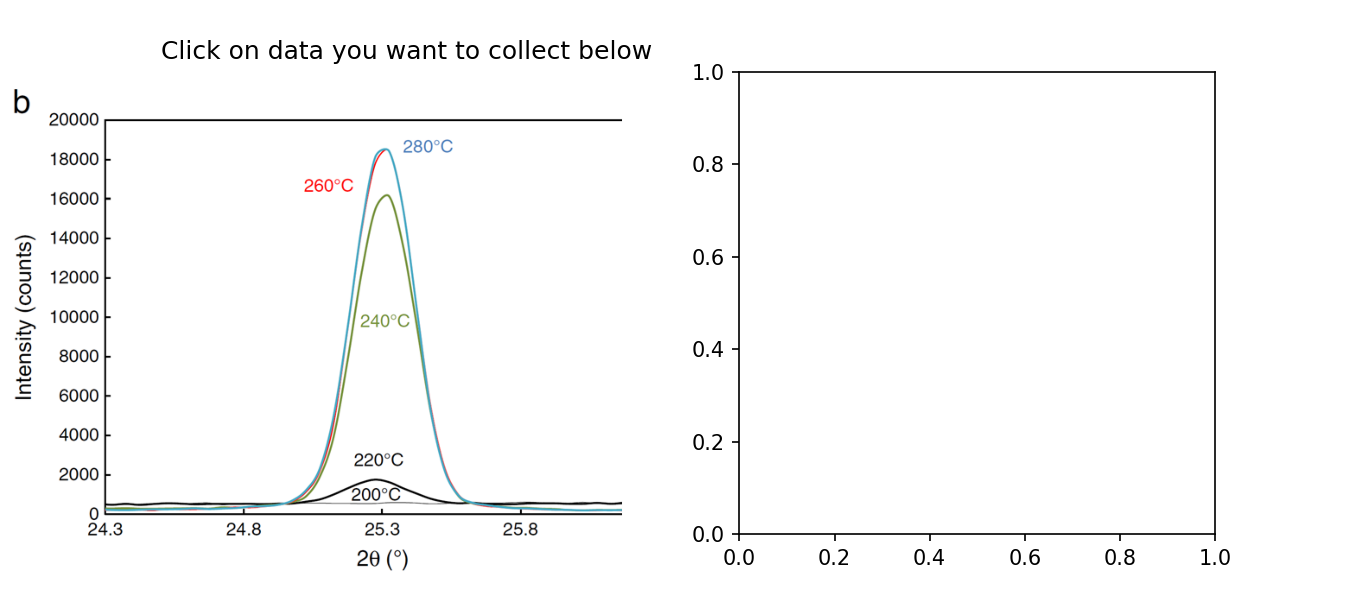

In [2]:
path=r"C:\Users\Sean\OneDrive - Virginia Tech\Documents\Teaching\2114 & 3114 Math I & II\git_2114_3114\images"
filename='xrd data.png'
fullpath=os.path.join(path, filename)

selectdata(fullpath)

Your output from above should look something like this: 
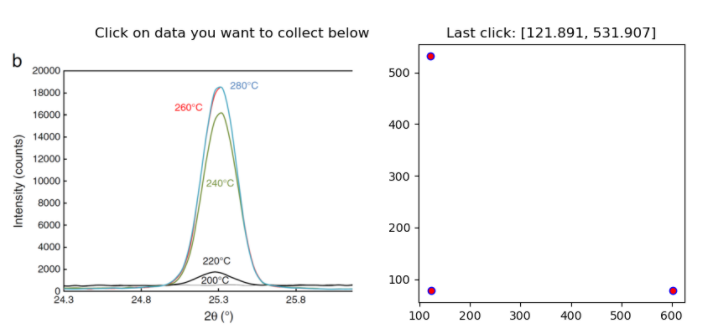

#### Running the cell below will copy the three points above "pixel_positions" into variable "pix_pts".  But first, fill in the corresponding plot values for these in plot_pts below. 

In [3]:
pix_pts=pixel_positions #this statement is good if you picked three points on the image above
plot_pts=[[25.8,0],[24.3,0],[24.3,20000]]

## Now repeat for the 280 degree curve

<IPython.core.display.Javascript object>


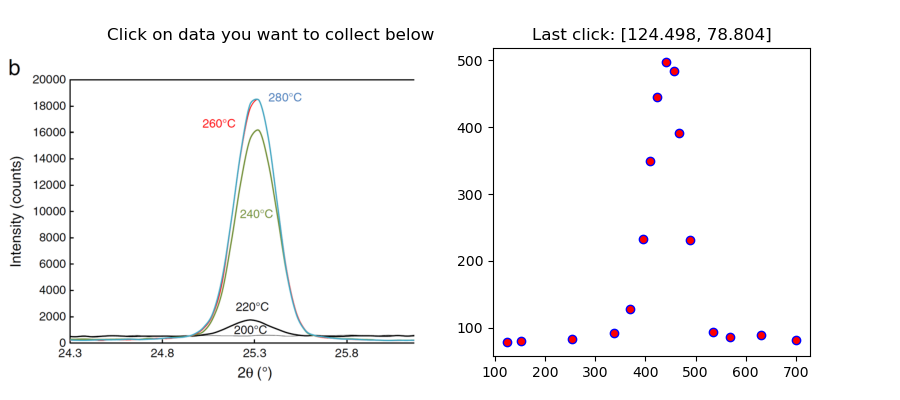

In [4]:
selectdata(fullpath)

My data looked like: 
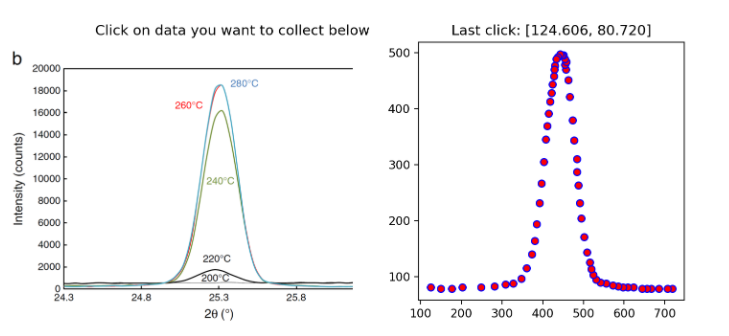

In [5]:
pix_data280=pixel_positions

## repeat again for the 240  degree data

<IPython.core.display.Javascript object>


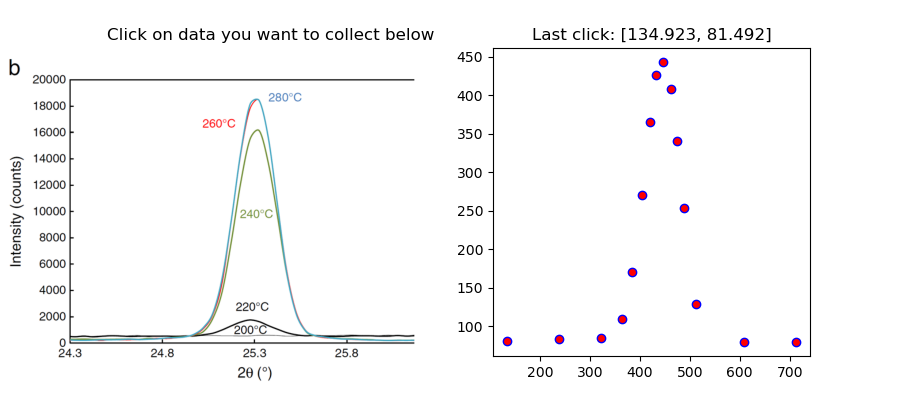

In [6]:
selectdata(fullpath)

My data looked like: 
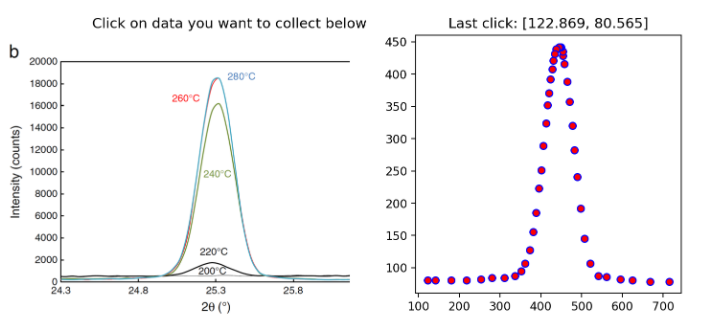

In [7]:
pix_data240=pixel_positions

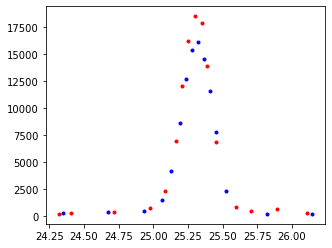

In [8]:
%matplotlib inline
plot_data1=cal(pix_pts, plot_pts, pix_data280)
plot_data2=cal(pix_pts, plot_pts, pix_data240)
    
plt.subplots(figsize=[5,4])
plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.')
plt.plot(plot_data2[:,0], plot_data2[:,1], 'b.')
plt.show()

## now we want the area under each curve. Let's fit the data to a peak function and then we can integrate the fit to get the area.

Lorentzian
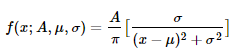

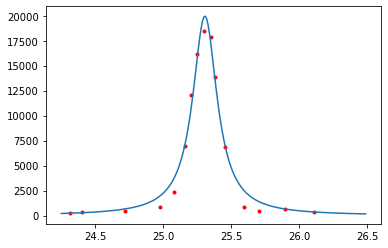

In [12]:
from scipy.optimize import curve_fit

def lorentzian(x, amplitude, mean, stddev):
    return amplitude * (stddev/((x-mean)**2+stddev**2))

#define our function here.  Let's use a lorentzian
popt, _ = curve_fit(lorentzian, plot_data1[:,0], plot_data1[:,1], bounds=[[0, 24, 0],[20000,26,2]])
# the bounds in the fit above help the routine find a fit.  These are given as [[lower],[upper]]
# where lower correspond to the lower bound for our three variables "amplitude", "mean", & "stddev"
# the order is taken from the order given in the function lorentzian above

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt));

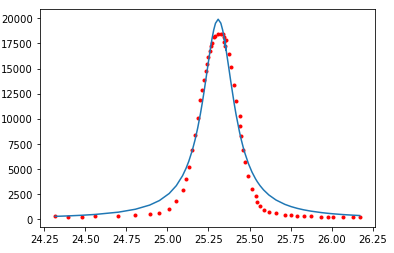

In [13]:
model=lorentzian
import scipy.integrate as integrate
import scipy.special as special
result = integrate.quad(lambda x: model(x, *popt), 24.5, 26.1)
result

(6249.197105915093, 1.754446259740513e-07)

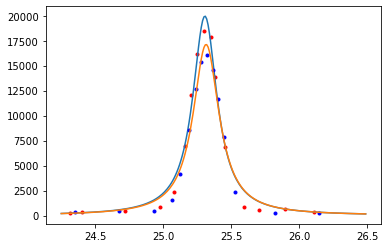

In [16]:
model=lorentzian

popt2, _ = curve_fit(model, plot_data2[:,0], plot_data2[:,1], bounds=[[0, 24, 0],[20000,26,2]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt));
plt.plot(plot_data2[:,0], plot_data2[:,1], 'b.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt2));

My output using the weighted lorentzian + gaussian model 
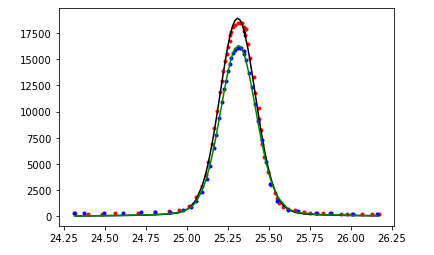

In [17]:
result2 = integrate.quad(lambda x: model(x, *popt2), 24.5, 26.1)
result2

(5692.3666412600705, 2.4938407116781842e-09)

In [19]:
print(f'If we take the curve at 280 C to represent fully recrystallized with an area of {result[0]:.0f}')
print(f'then we can divide all integrated areas by {result[0]:.0f}')
print(f'the normalized intensity at 240 C = {result2[0]:.0f} / {result[0]:.0f}= {result2[0]/result[0]:.2f}')

If we take the curve at 280 C to represent fully recrystallized with an area of 6249
then we can divide all integrated areas by 6249
the normalized intensity at 240 C = 5692 / 6249= 0.91


## Now you try the above with a Gaussian fit which will do a much better job

#### Now let's look at the Normalized Intensity vs time data

<IPython.core.display.Javascript object>


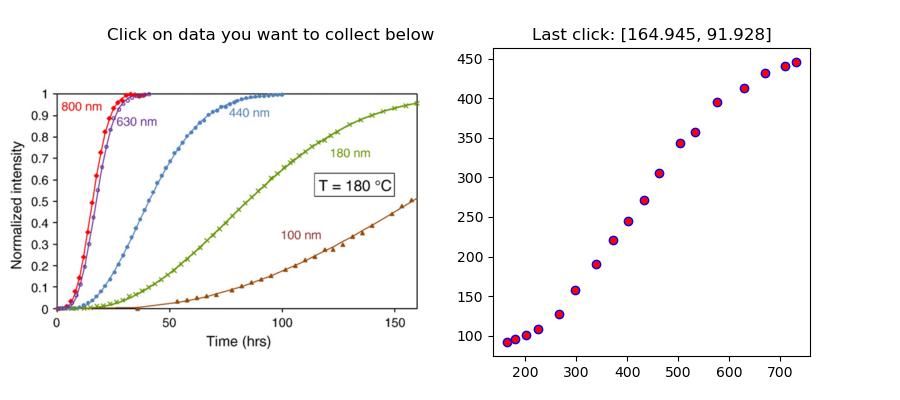

In [225]:
path=Path("C:/Users/sgc/Google Drive/Teaching/2114 & 3114 Math I & II/3114 Python/images/")
filename='crystalliz data intensity time.png'
fullpath=path / filename

selectdata(fullpath)

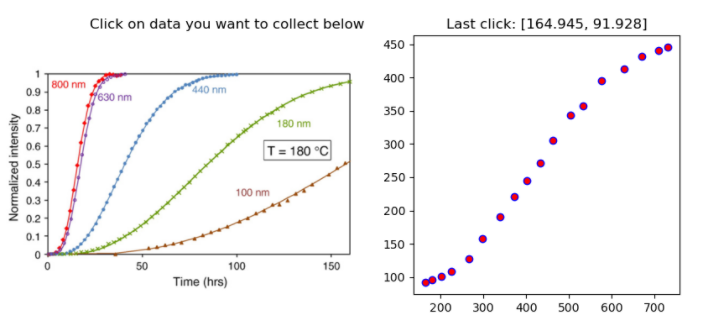

In [226]:
dataset1=pixel_positions

<IPython.core.display.Javascript object>


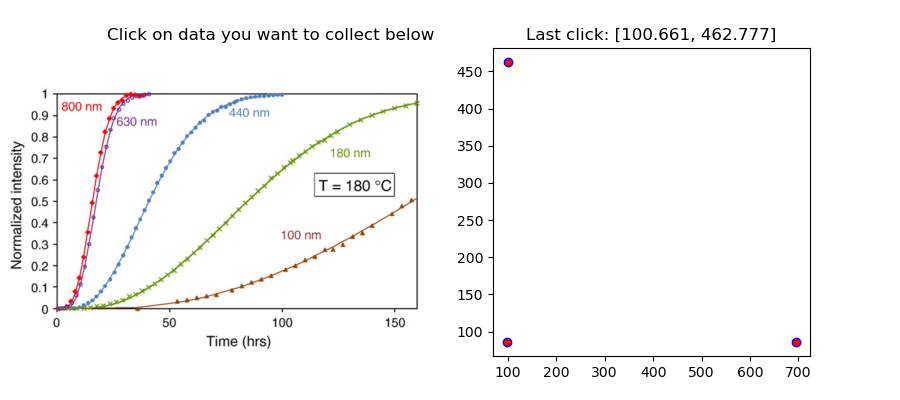

In [232]:
selectdata(fullpath)

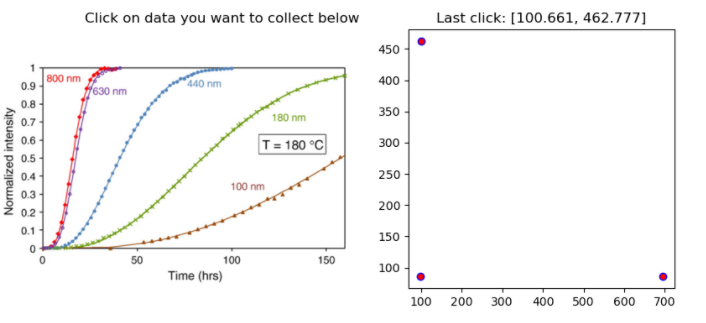

In [228]:
dataset2=pixel_positions

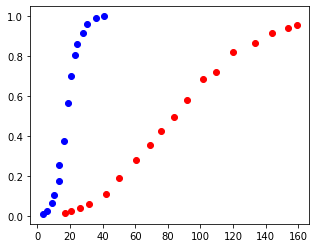

In [163]:
# being a bit more careful and magnifying my window, I got the following calibration values:
pixpts=[[694,86],[99,86],[100,463]]
pltpts=[[150,0],[0,0],[0,1]]
plot_data1=cal(pixpts, pltpts, dataset1)
plot_data2=cal(pixpts, pltpts, dataset2)
    
plt.subplots(figsize=[5,4])
plt.plot(plot_data1[:,0], plot_data1[:,1], 'ro')
plt.plot(plot_data2[:,0], plot_data2[:,1], 'bo')
plt.show()

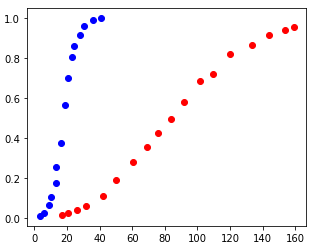

In [49]:
# dataset1=[[730.3000886524823, 445.93513593380624],
#  [709.1653368794326, 440.65144799054383],
#  [670.418291962175, 431.8453014184398],
#  [628.1487884160756, 412.47177895981093],
#  [575.3119089834515, 394.8594858156029],
#  [533.0424054373523, 357.873670212766],
#  [503.1015070921986, 343.7838356973996],
#  [462.5932328605201, 305.0367907801419],
#  [432.6523345153664, 271.5734338061466],
#  [400.950206855792, 245.1549940898346],
#  [372.7705378250591, 220.4977836879433],
#  [339.30718085106383, 190.55688534278966],
#  [297.0376773049645, 157.0935283687944],
#  [265.3355496453901, 127.15263002364071],
#  [224.8272754137116, 107.77910756501183],
#  [201.93129432624113, 100.73419030732862],
#  [180.7965425531915, 95.45050236406621],
#  [164.94547872340425, 91.9280437352246]]

In [50]:
# dataset2=[[261.81309101654847, 462.7768912529551],
#  [242.4395685579196, 459.2544326241135],
#  [221.30481678486998, 448.6870567375887],
#  [210.73744089834514, 431.0747635933807],
#  [194.88637706855792, 409.94001182033105],
#  [191.36391843971631, 388.8052600472814],
#  [180.7965425531915, 350.0582151300237],
#  [173.75162529550826, 298.9825650118204],
#  [164.94547872340425, 226.77216312056743],
#  [152.61687352245863, 180.9802009456265],
#  [150.85564420803783, 151.03930260047287],
#  [140.288268321513, 124.62086288416083],
#  [133.24335106382978, 110.53102836879435],
#  [122.67597517730496, 94.67996453900713],
#  [112.10859929078013, 89.39627659574472]]

In [164]:
plot_data1

array([[1.58910593e+02, 9.54735109e-01],
       [1.53586038e+02, 9.40720021e-01],
       [1.43823764e+02, 9.17361542e-01],
       [1.33180542e+02, 8.65972888e-01],
       [1.19872097e+02, 8.19255931e-01],
       [1.09240653e+02, 7.21150319e-01],
       [1.01701949e+02, 6.83776753e-01],
       [9.15156891e+01, 5.80999445e-01],
       [8.39899405e+01, 4.92237225e-01],
       [7.60154735e+01, 4.22161788e-01],
       [6.89278436e+01, 3.56758047e-01],
       [6.05117248e+01, 2.77339218e-01],
       [4.98779244e+01, 1.88576998e-01],
       [4.19058130e+01, 1.09158170e-01],
       [3.17065981e+01, 5.77695161e-02],
       [2.59392130e+01, 3.90827329e-02],
       [2.06146575e+01, 2.50676455e-02],
       [1.66209465e+01, 1.57242539e-02]])

In [165]:
plot_data2

array([[4.07933654e+01, 9.99408200e-01],
       [3.59116396e+01, 9.90064808e-01],
       [3.05906173e+01, 9.62034633e-01],
       [2.79383504e+01, 9.15317675e-01],
       [2.39564167e+01, 8.59257326e-01],
       [2.30825348e+01, 8.03196976e-01],
       [2.04444007e+01, 7.00419669e-01],
       [1.87025256e+01, 5.64940491e-01],
       [1.65307759e+01, 3.73400963e-01],
       [1.34533454e+01, 2.51936873e-01],
       [1.30293595e+01, 1.72518044e-01],
       [1.03829813e+01, 1.02442607e-01],
       [8.61637362e+00, 6.50690408e-02],
       [5.96292892e+00, 2.30237786e-02],
       [3.30241780e+00, 9.00869124e-03]])

#### now we just need to fit with avrami equation

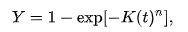

[1.76457705e-05 2.38940519e+00]


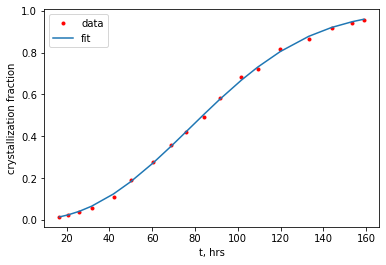

In [178]:
from scipy.optimize import curve_fit
%matplotlib inline

def avrami(t,k,n):
    return(1-np.exp(-k*t**n))

# nonlinear fits can be a bit sensitive so you may have to play with the initial guess "p0" to get a good fit
popt, _ = curve_fit(avrami, plot_data1[:,0], plot_data1[:,1], p0=[1e-3, 2])

print(popt)
plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.', label='data');
plt.plot(plot_data1[:,0], avrami(plot_data1[:,0], *popt), label="fit");
plt.xlabel('t, hrs')
plt.ylabel('crystallization fraction')
plt.legend();
plt.show()


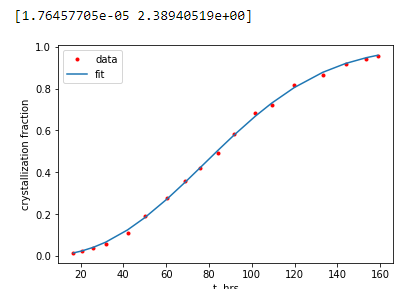

The paper gets n = 2.25, k=1.2e-5 and we get 2.39, 1.76e-5 for the 180nm data.
The paper gets n = 2.5 and we get  ... for the 630 nm data.  

Why are your answers different than the values from the paper?  Because the authors performed a fit using a bad function.  They chose to fit $y=1-exp(-k  (t-t_0)^n)$  rather than $y=1-exp(-k  t^n)$.  

They added the $t_0$ parameter because they could not fit the data without it.  They claimed that $t_0$ represented an incubation time for nucleation but this is already built into the Avrami equation!  

# Appendix

### Three additional peak functions that are sometimes used

Gaussian
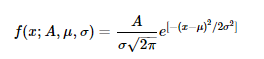

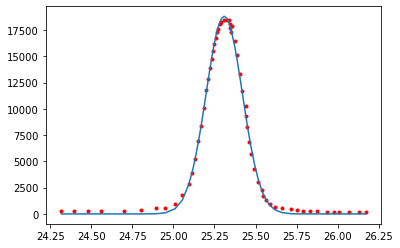

In [46]:
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-1/2*((x - mean) / stddev)**2)

popt, _ = curve_fit(gaussian, plot_data1[:,0], plot_data1[:,1], p0=[10000, 25, 0.5], bounds=[[5000, 24, 0],[20000,26,2]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], gaussian(plot_data1[:,0], *popt));

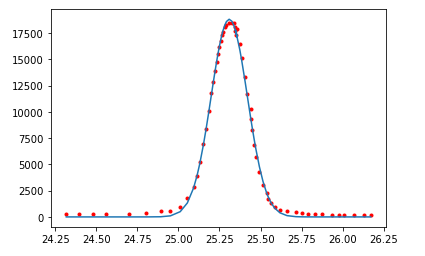

Voigt
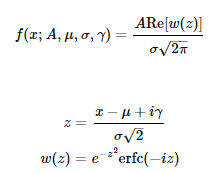

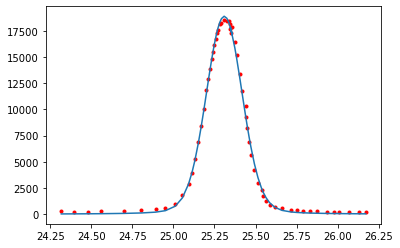

In [128]:
from scipy.special import erfc

# def voigt(x, amplitude, mean, stddev, gamma):
#     z=(x-mean+gamma*1j)/(stddev*np.sqrt(2))
#     w=np.exp(-1*z**2)*erfc(-z*1j)
#     return amplitude * np.real(w)/(stddev*np.sqrt(2*np.pi))

def voigt(x, amplitude, mean, stddev,c):
    gamma=c*stddev #gamma is often constrained to equal stddev this line lets us fit gamma but define it relative to stddev
    z=(x-mean+gamma*1j)/(stddev*np.sqrt(2))
    w=np.exp(-1*z**2)*erfc(-z*1j)
    return amplitude * np.real(w)/(stddev*np.sqrt(2*np.pi))

popt, _ = curve_fit(voigt, plot_data1[:,0], plot_data1[:,1], bounds=[[300, 24, 0,0.01],[20000,26,2,1]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], voigt(plot_data1[:,0], *popt));

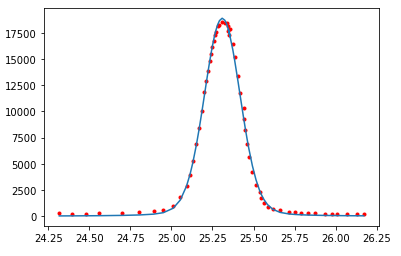

Weighted sum of Gaussian and Lorentz
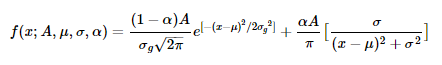


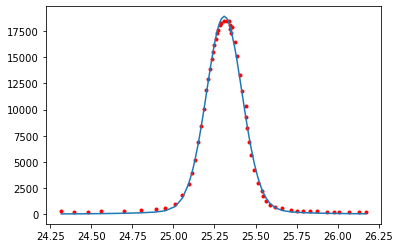

In [163]:
def gaussian(x, amplitude, mean, stddev, alpha):
    stddevg=stddev/(2*np.log(2))
    return (1-alpha)*amplitude * np.exp(-1/2*((x - mean) / stddevg)**2)

def lorentzian(x, amplitude, mean, stddev, alpha):
    return alpha*amplitude * (stddev/((x-mean)**2+stddev**2))

def model(x,amplitude, mean, stddev, alpha):
    return(gaussian(x,amplitude, mean, stddev, alpha)+lorentzian(x,amplitude, mean, stddev, alpha))

popt, _ = curve_fit(model, plot_data1[:,0], plot_data1[:,1], bounds=[[0, 24, 0,0],[20000,26,2,1]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], model(plot_data1[:,0], *popt));

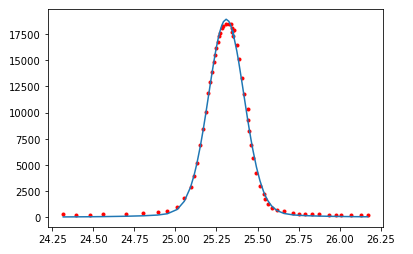